In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as mpl

In [3]:
from sklearn.model_selection._split import _BaseKFold
class PurgedKFold(_BaseKFold):
    '''
    Extend Kfold to work with labels that span intervals
    the train is purged of observations overlapping test-label intervals
    test set is assumed contiguous (shuffle=False), w/o training examples in between'''
    def __init__(self, n_splits=3, t1=None, pctEmbargo=0.):
        if not isinstance(t1, pd.Series):
            raise ValueError('must be pd series')
        super(PurgedKFold, self).__init__(n_splits, shuffle=False, random_state=None)
        self.t1=t1
        self.pctEmbargo=pctEmbargo
    def split(self, X, y=None, groups=None):
        if(X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and thruDateValues must have the same index')
        indices = np.arange(X.shape[0])
        mbrg = int(X.shape[0]*self.pctEmbargo)
        test_starts=[(i[0], i[-1]+1) for i in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for i,j in test_starts:
            t0 = self.t1.index[i] #start of test set
            test_indices = indices[i:j]
            maxT1Idx = self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices = self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            train_indices = np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices, test_indices

In [4]:
class MyPipeline(Pipeline):
    def fit(self, X, y, sample_weight=None, **fit_params):
        if sample_weight is not None:
            fit_params[self.steps[-1][0]+'__sample_weight']=sample_weight
        return super(MyPipeline,self).fit(X,y, **fit_params)

In [5]:
#grid search cv
def clfHyperFit(feat, lb1, t1, pipe_clf, param_grid, cv=3, bagging=[0, None, 1.], rngSearchIter=0, n_jobs=-1, pctEmbargo=0, **fit_params):
    if set(lb1.values)=={0,1}:
        scoring='f1'#use scoring method f1 for meta labeling because of high number of negatives in this use case
    else: 
        scoring='neg_log_loss'
    #1. Hyperparameter search, on training data
    inner_cv= PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)
    if rndSearchIter==0:
        gs = GridSearchCV(estimator=pipe_clf,param_grid=param_grid, scoring=scoring, cv=inner_cv, n_jobs=n_jobs, iid=False)
    else:
        gs = RandomizedSearchCV(estimator=pipe_clf, param_dsitributions=param_grid, scoring=scoring, cv=inner_cv, n_jobs=n_jobs, iid=False, n_iter=rndSearchIter)
    gs = gs.fit(feat, lb1, **fit_params).best_estimator_ 
    #2. Fit validated model on the rest of the dataset
    if bagging[1]>0:
        gs = BaggingClassifier(base_estimator=MyPipeline(gs.steps), n_estimators=int(bagging[0]), max_samples=float(bagging[1]),max_features=float(bagging[2]), n_jobs=n_jobs)
        gs = gs.fit(feat, lb1, sample_weight=fit_params[gs.base_estimator.steps[-1][0]+'__sample_weight'])
        gs = Pipeline([('bag', gs)])
    return gs
        

KstestResult(statistic=0.008178548334759728, pvalue=0.5153847378549393)
count    10000.000000
mean        70.602278
std        174.120001
min          0.001001
25%          0.029361
50%          0.969305
75%         28.917796
max        999.480631
dtype: float64


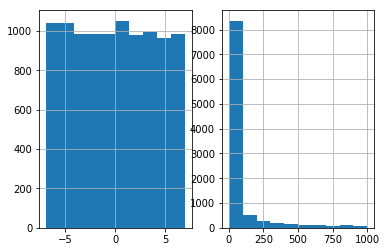

In [7]:
from scipy.stats import rv_continuous, kstest

class logUniform_gen(rv_continuous):
    #random numbers log-uniformely distributed between 1 and e
    def _cdf(self, x):
        return np.log(x/self.a)/np.log(self.b/self.a)
def logUniform(a=1, b=np.exp(1)):
    return logUniform_gen(a=a, b=b, name='logUniform')

a,b,size = 1E-3, 1E3, 10000
vals = logUniform(a=a, b=b).rvs(size=size)
print(kstest(rvs=np.log(vals), cdf='uniform', args=(np.log(a), np.log(b/a)), N=size))
print(pd.Series(vals).describe())
mpl.subplot(121)
pd.Series(np.log(vals)).hist()
mpl.subplot(122)
pd.Series(vals).hist()
mpl.show()
